In [46]:
from load_data import load_breast_cancer_data, load_mushroom_data, load_wine_quality_data

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

import numpy as np

import time

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data loading and preprocessing
Let's load the data, standardize it and split it into training and test sets.

In [47]:
# Read data
#X, y = load_breast_cancer_data('../data/breast-cancer-wisconsin-data/data.csv')
#X, y = load_mushroom_data('../data/mushroom-classification/mushrooms.csv')
X, y = load_wine_quality_data('../data/wine-quality/winequality-white.csv')
print('Total number of examples in the dataset: %d' % X.shape[0])
print('Fraction of positive examples: %.2f%%' % (y[y == 1].shape[0]/y.shape[0]*100.0))

# Standardize data
X = preprocessing.scale(X)

# Split into training and test data. Use random_state to get the same results in every run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=18)

# Data structures for storing best accuracies, training time and test time
num_classifiers = 5
best_accuracy = np.zeros(num_classifiers)
train_time = np.zeros(num_classifiers)
test_time = np.zeros(num_classifiers)

Total number of examples in the dataset: 4898
Fraction of positive examples: 66.52%


The fraction of positive examples suggests that our data is balanced.

# Decision tree
Let's first train a decision tree without any optimization to get a feel for its performance on the given data.

In [48]:
clf_dt = tree.DecisionTreeClassifier(random_state=7)
clf_dt.fit(X_train, y_train)
y_pred = clf_dt.predict(X_test)
dt_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of decision tree without hyperparameter tuning is %.2f%%' % (dt_accuracy*100))

Accuracy of decision tree without hyperparameter tuning is 76.73%


## Validation curve
We will use a form of pre-pruning to prevent overfitting. Performance of a decision tree is affected by its maximum depth. A tree with a large depth will try to fit the training data exactly and is likely to result in overfitting. Let's plot the training and cross-validation scores to get a sense of how much the tree overfits with an increase in the depth.

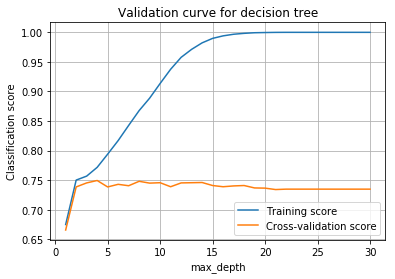

In [49]:
depth_range = np.arange(30) + 1
train_scores, test_scores = validation_curve(clf_dt, X_train, y_train, param_name="max_depth", param_range=depth_range, cv=5,
                                            n_jobs=4)

plt.figure()
#plt.xticks(depth_range)
plt.plot(depth_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(depth_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for decision tree')
plt.xlabel('max_depth')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

For low values of max_depth, the tree is excessively pruned and thus suffers from underfitting as both the training and cross-validation scores are low. The training score keeps increasing as max_depth increases. However, the cross-validation score first increases but starts decreasing at a certain point and then plateaus. Thus, at higher values of max_depth, the tree starts to overfit.

## Hyperparameter tuning
Based on the validation curve above, we will define an appropriate grid for max_depth, tune it and find out the best accuracy using a decision tree.

In [50]:
depth_range = np.arange(20) + 1
tuned_params = {'max_depth' : depth_range}
clf_dt = GridSearchCV(clf_dt, param_grid=tuned_params, cv=5, n_jobs=4)
t0 = time.time()
clf_dt.fit(X_train, y_train)
t1 = time.time()
train_time[0] = t1 - t0
print('Completed training in %f seconds' % train_time[0])
best_clf_dt = clf_dt
best_dt_params = clf_dt.best_params_
print("Best parameters set for decision tree found on development set:")
print(best_dt_params)
t0 = time.time()
y_pred = clf_dt.predict(X_test)
t1 = time.time()
test_time[0] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[0])
best_accuracy[0] = accuracy_score(y_test, y_pred)
print('Accuracy of decision tree is %.2f%%' % (best_accuracy[0] * 100))

Completed training in 3.108074 seconds
Best parameters set for decision tree found on development set:
{'max_depth': 4}
Inference time on test data: 0.000999 seconds
Accuracy of decision tree is 75.51%


## Learning curve

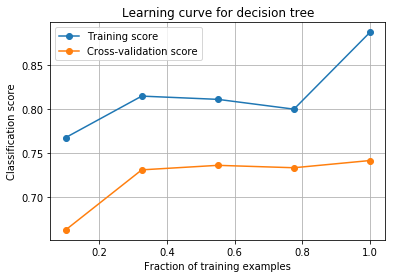

In [51]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_dt, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for decision tree')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

# Neural network
For ease of analysis, we will experiment with a small neural network with 2 hidden layers containing 5 and 2 nodes respectively. Let's first evaluate the performance of the network without any hyperparameter tuning.

In [52]:
clf_nn = MLPClassifier(hidden_layer_sizes=(5, 2), random_state=7, max_iter=1000)
clf_nn.fit(X_train, y_train)
y_pred = clf_nn.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of neural network without hyperparameter tuning is %.2f%%' % (nn_accuracy * 100))

Accuracy of neural network without hyperparameter tuning is 76.28%


## Validation curve
Performance of a neural network is very sensitive to its learning rate and regularization parameter. Let's get a feel for it by plotting validation curves for both the parameters.

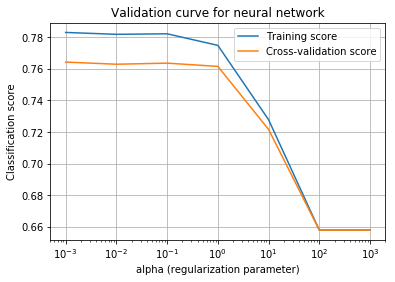

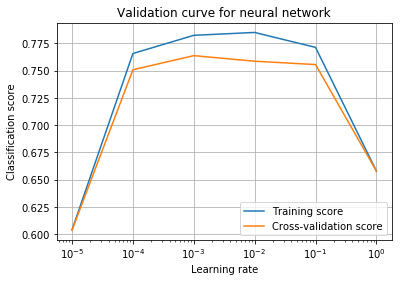

In [53]:
# Regularization parameter
alpha_range = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(clf_nn, X_train, y_train, param_name="alpha", param_range=alpha_range, cv=5,
                                            n_jobs=4)

plt.figure()
plt.semilogx(alpha_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(alpha_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for neural network')
plt.xlabel('alpha (regularization parameter)')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

# Learning rate
lr_range = np.logspace(-5, 0, 6)
train_scores, test_scores = validation_curve(clf_nn, X_train, y_train, param_name="learning_rate_init", param_range=lr_range, 
                                             cv=5, n_jobs=4)

plt.figure()
plt.semilogx(lr_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(lr_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for neural network')
plt.xlabel('Learning rate')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_2.png')
plt.show()

## Hyperparameter tuning
Based on the validation curves plotted above, we will define an appropriate grid for each parameter and tune them.

In [54]:
# Define grid for grid search after observing validation curves
alpha_range = np.logspace(-1, 2, 5)
lr_range = np.logspace(-5, 0, 6)
tuned_params = {'alpha' : alpha_range, 'learning_rate_init' : lr_range}
clf_nn = GridSearchCV(clf_nn, param_grid=tuned_params, cv=5, n_jobs=4)
t0 = time.time()
clf_nn.fit(X_train, y_train)
t1 = time.time()
train_time[1] = t1 - t0
print('Completed training in %f seconds' % train_time[1])
best_clf_nn = clf_nn
best_params = clf_nn.best_params_
print("Best parameters set found on development set:")
print(best_params)

Completed training in 105.463418 seconds
Best parameters set found on development set:
{'alpha': 0.1, 'learning_rate_init': 0.01}


## Learning curve

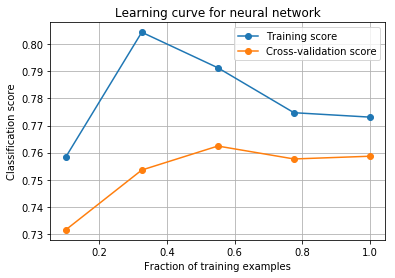

In [55]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_nn, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for neural network')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

## Loss curves
We will now observe how training error decreases with epochs.

C:\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Accuracy of neural network is 77.04%


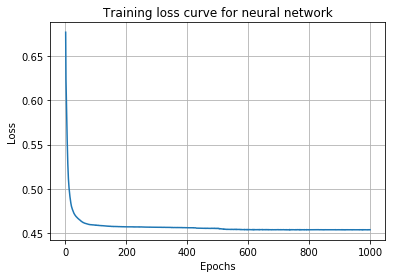

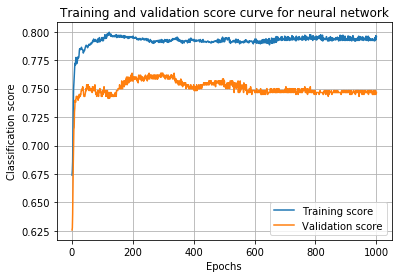

In [56]:
clf_nn = MLPClassifier(hidden_layer_sizes=(5, 2), random_state=7, max_iter=1, warm_start=True)
clf_nn.set_params(alpha=best_params['alpha'], learning_rate_init=best_params['learning_rate_init'])
num_epochs = 1000
train_loss = np.empty(num_epochs)
train_scores = np.empty(num_epochs)
val_scores = np.empty(num_epochs)
# Split training set into training and validation
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=18)
for i in range(num_epochs):
    clf_nn.fit(X_train1, y_train1)
    train_loss[i] = clf_nn.loss_
    train_scores[i] = accuracy_score(y_train1, clf_nn.predict(X_train1))
    val_scores[i] = accuracy_score(y_val, clf_nn.predict(X_val))

y_pred = clf_nn.predict(X_test)
nn_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of neural network is %.2f%%' % (nn_accuracy * 100))

xrange = np.arange(num_epochs) + 1
plt.figure()
plt.plot(xrange, train_loss)
plt.title('Training loss curve for neural network')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.grid()
#plt.savefig(fig_path + 'nn_train_loss.png')
plt.show()

plt.figure()
plt.plot(xrange, train_scores, label='Training score')
plt.plot(xrange, val_scores, label='Validation score')
plt.title('Training and validation score curve for neural network')
plt.xlabel('Epochs')
plt.ylabel("Classification score")
plt.grid()
plt.legend(loc="best")
#plt.savefig(fig_path + 'nn_score_curve.png')
plt.show()

## Evaluate optimal model
Let's find the test accuracy of the neural network with its hyperparameters tuned to their optimal values.

In [57]:
t0 = time.time()
y_pred = best_clf_nn.predict(X_test)
t1 = time.time()
test_time[1] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[1])
best_accuracy[1] = accuracy_score(y_test, y_pred)
print('Best accuracy of neural network is %.2f%%' % (best_accuracy[1] * 100))

Inference time on test data: 0.000000 seconds
Best accuracy of neural network is 76.63%


# Boosting
We will use AdaBoost with decision stumps.

In [58]:
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, random_state=7)
clf_boosted.fit(X_train, y_train)
y_pred = clf_boosted.predict(X_test)
boosted_accuracy = accuracy_score(y_test, y_pred)
print('Accuracy of Adaboost without hyperparameter tuning is %.2f%%' % (boosted_accuracy * 100))

Accuracy of Adaboost without hyperparameter tuning is 76.02%


## Validation curve
Number of weak learners is a hyperparameter we have to tune. To understand how it affects the performance of the classifier, we will plot training and cross-validation scores wrt the number of learners.

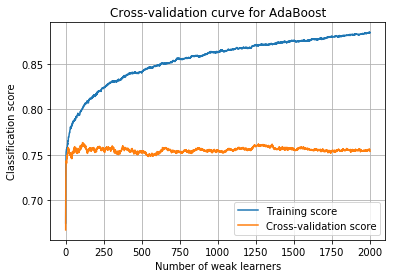

In [59]:
# Define AdaBoost learner
num_learners = 2000
dt_stump = tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=num_learners, random_state=7)

# Cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, random_state=7)
train_scores = np.zeros((num_learners, num_folds))
val_scores = np.zeros((num_learners, num_folds))
for idx, (train_index, test_index) in enumerate(kf.split(X_train)):
    clf_boosted.fit(X_train[train_index], y_train[train_index])
    train_scores[:, idx] = np.asarray(list(clf_boosted.staged_score(X_train[train_index], y_train[train_index])))
    val_scores[:, idx] = np.asarray(list(clf_boosted.staged_score(X_train[test_index], y_train[test_index])))

n_estimators_range = np.arange(num_learners) + 1
plt.figure()
plt.plot(n_estimators_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(n_estimators_range, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.title('Cross-validation curve for AdaBoost')
plt.xlabel('Number of weak learners')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
plt.show()

## Evaluate optimal model

In [60]:
num_learners_optimal = np.argmax(np.mean(val_scores, axis=1)) + 1
print('Optimal number of learners for AdaBoost: %d' % num_learners_optimal)
best_clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=num_learners_optimal, random_state=7)
t0 = time.time()
best_clf_boosted.fit(X_train, y_train)
t1 = time.time()
train_time[2] = t1 - t0
print('Completed training in %f seconds' % train_time[2])
t0 = time.time()
y_pred = best_clf_boosted.predict(X_test)
t1 = time.time()
test_time[2] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[2])
best_accuracy[2] = accuracy_score(y_test, y_pred)
print('Accuracy of Adaboost with the best hyperparameters is %.2f%%' % (best_accuracy[2] * 100))

Optimal number of learners for AdaBoost: 112
Completed training in 0.480474 seconds
Inference time on test data: 0.046970 seconds
Accuracy of Adaboost with the best hyperparameters is 77.14%


## Learning curve

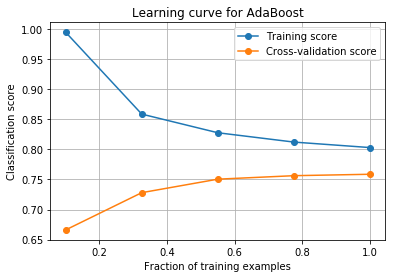

In [61]:
train_sizes = np.linspace(0.1, 1.0, 5)
best_clf_boosted = AdaBoostClassifier(base_estimator=dt_stump, n_estimators=num_learners_optimal, random_state=7)
_, train_scores, test_scores = learning_curve(best_clf_boosted, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for AdaBoost')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

# SVM
We will use an SVM with a linear kernel.

In [62]:
svm_linear = svm.SVC(kernel='linear')
svm_linear.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

# Validation curve
Let's plot the training and cross-validation scores wrt the penalty parameter $C$ (which controls regularization).

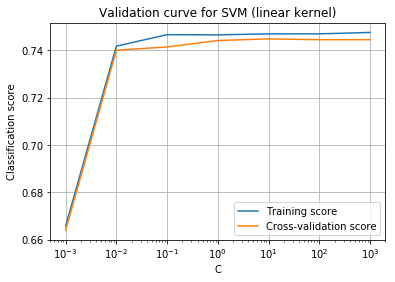

In [63]:
C_range = np.logspace(-3, 3, 7)
train_scores, test_scores = validation_curve(svm_linear, X_train, y_train, param_name="C", param_range=C_range, cv=5, n_jobs=4)

plt.figure()
plt.semilogx(C_range, np.mean(train_scores, axis=1), label='Training score')
plt.semilogx(C_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for SVM (linear kernel)')
plt.xlabel('C')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

# Hyperparameter tuning
Based on the validation curve plotted above, we will now define an appropriate grid for $C$ and tune it.

In [64]:
C_range = np.logspace(-2, 1, 10)
tuned_params = {'C' : C_range}
svm_linear = GridSearchCV(svm_linear, param_grid=tuned_params, cv=5, n_jobs=4)
t0 = time.time()
svm_linear.fit(X_train, y_train)
t1 = time.time()
train_time[3] = t1 - t0
print('Completed training in %f seconds' % train_time[3])
best_clf_svm = svm_linear
best_params = svm_linear.best_params_
print("Best parameters set found on development set:")
print(best_params)
t0 = time.time()
y_pred = best_clf_svm.predict(X_test)
t1 = time.time()
test_time[3] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[3])
best_accuracy[3] = accuracy_score(y_test, y_pred)
print('Best accuracy with SVM (linear kernel) is %.2f%%' % (best_accuracy[3] * 100))

Completed training in 10.871261 seconds
Best parameters set found on development set:
{'C': 0.046415888336127774}
Inference time on test data: 0.054968 seconds
Best accuracy with SVM (linear kernel) is 75.71%


# Learning curve

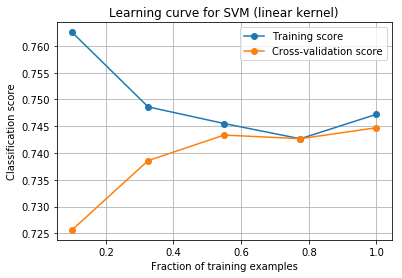

In [65]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_svm, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for SVM (linear kernel)')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

# kNN

## Validation curve
Let's find out how the accuracies are affected by the number of neighbors.

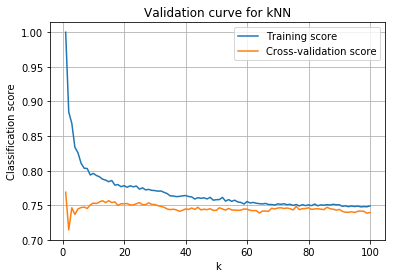

In [66]:
k_range = np.arange(1, 101)
train_scores, test_scores = validation_curve(KNeighborsClassifier(), X_train, y_train, param_name="n_neighbors", 
                                             param_range=k_range, cv=5, n_jobs=4)

plt.figure()
plt.plot(k_range, np.mean(train_scores, axis=1), label='Training score')
plt.plot(k_range, np.mean(test_scores, axis=1), label='Cross-validation score')
plt.title('Validation curve for kNN')
plt.xlabel('k')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_validation_curve_1.png')
plt.show()

## Evaluate optimal model
We will choose the value of k which gives the best cross-validation score and evaluate test score with that.

In [67]:
k_optimal = np.argmax(np.mean(test_scores, axis=1)) + 1
print('Optimal value of k: %d' % k_optimal)
best_clf_knn = KNeighborsClassifier(n_neighbors=k_optimal)
t0 = time.time()
best_clf_knn.fit(X_train, y_train)
t1 = time.time()
train_time[4] = t1 - t0
print('Completed training in %f seconds' % train_time[4])
t0 = time.time()
y_pred = best_clf_knn.predict(X_test)
t1 = time.time()
test_time[4] = t1 - t0
print('Inference time on test data: %f seconds' % test_time[4])
best_accuracy[4] = accuracy_score(y_test, y_pred)
print('Accuracy of kNN with k = %d is %.2f%%' % (k_optimal, best_accuracy[4] * 100))

Optimal value of k: 1
Completed training in 0.013990 seconds
Inference time on test data: 0.250845 seconds
Accuracy of kNN with k = 1 is 76.99%


## Learning curve

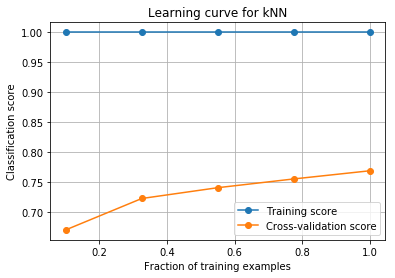

In [68]:
train_sizes = np.linspace(0.1, 1.0, 5)
_, train_scores, test_scores = learning_curve(best_clf_knn, X_train, y_train, train_sizes=train_sizes, cv=5, n_jobs=4)

plt.figure()
plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label='Cross-validation score')
plt.title('Learning curve for kNN')
plt.xlabel('Fraction of training examples')
plt.ylabel("Classification score")
plt.legend(loc="best")
plt.grid()
#plt.savefig(fig_path + 'dt_learning_curve.png')
plt.show()

# Comparing the classifiers
We will now compare the 5 classifiers with respect to accuracy, training time and inference time

In [69]:
classifiers = ('Decision tree', 'Neural network', 'AdaBoost', 'SVM', 'kNN')
y_pos = np.arange(len(classifiers))

## Accuracy

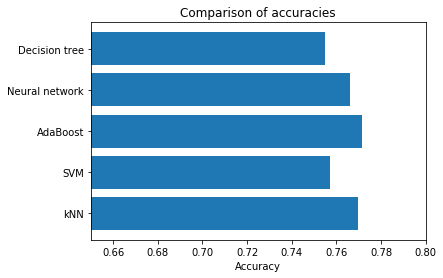

In [73]:
plt.figure()
plt.barh(y_pos, best_accuracy)
plt.gca().set_yticks(y_pos)
plt.gca().set_xlim(0.65, 0.8)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of accuracies')
plt.xlabel('Accuracy')
plt.show()

## Training time

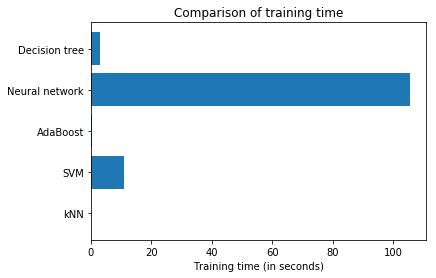

In [71]:
plt.figure()
plt.barh(y_pos, train_time)
plt.gca().set_yticks(y_pos)
#plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of training time')
plt.xlabel('Training time (in seconds)')
plt.show()

## Inference time

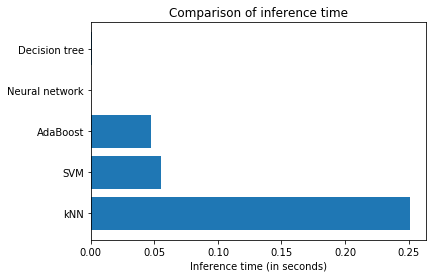

In [72]:
plt.figure()
plt.barh(y_pos, test_time)
plt.gca().set_yticks(y_pos)
#plt.gca().set_xlim(0.9, 1.0)
plt.gca().set_yticklabels(classifiers)
plt.gca().invert_yaxis()  # labels read top-to-bottom
plt.title('Comparison of inference time')
plt.xlabel('Inference time (in seconds)')
plt.show()